In [160]:
import pymc as pm
import csv
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler
from pytensor import tensor as pt
import pickle as pkl

In [113]:
# pre-process city temperature data
# this data is a stand-in for the actual data used in the Burke paper
avg_country_temp_per_year = {}
with open("data/local_data/city_temperature.csv") as temp_data_file:
    reader = csv.reader(temp_data_file)
    next(reader)
    for line in reader:
        country = line[1]
        year = line[6]
        temp = float(line[7])
        if temp > 0:
            if country not in avg_country_temp_per_year:
                avg_country_temp_per_year[country] = {}
            if country not in avg_country_temp_per_year[country]:
                avg_country_temp_per_year[country][year] = []
            avg_country_temp_per_year[country][year].append(temp)
for country in avg_country_temp_per_year:
    for year, obs in avg_country_temp_per_year[country].items():
        avg_country_temp_per_year[country][year] = np.mean(obs)

In [122]:
# pre-process gdp per capita data
country_gdp_per_year = {}
with open("data/burke/GrowthClimateDataset.csv") as econ_growth_file:
    reader = csv.reader(econ_growth_file)
    next(reader)
    for line in reader:
        country = line[7]
        if line[5] != "":
            gdp_pc = float(line[5])
            year = line[1]
            if country not in country_gdp_per_year:
                country_gdp_per_year[country] = {}
            country_gdp_per_year[country][year] = gdp_pc

In [115]:
# pre-process global temperature data
global_temperature = {}
with open("data/global_data/global_temp_monthly_avg.tsv") as file:
    reader = csv.reader(file, delimiter=" ")
    next(reader)
    next(reader)
    next(reader)
    for line in reader:
        line = [elem for elem in line if elem != ""]
        if int(line[0]) >= 1949:
            # omitting some data here - just taking the last value of each year for now
            global_temperature[line[0]] = line[2]

In [116]:
# pre-process global gdp-per-capita data
global_gdp = {}
with open("data/global_data/gdp_per_capita.tsv") as file:
    reader = csv.reader(file, delimiter="\t")
    next(reader)
    for line in reader:
        global_gdp[line[0]] = float(line[1])

In [55]:
# index observed data by year
all_years = set()
for year in global_gdp:
    all_years.add(year)
for year in global_temperature:
    all_years.add(year)
global_gdp_observed = []
global_temperature_observed = []
for year in all_years:
    if year in global_gdp:
        global_gdp_observed.append(global_gdp[year])
    else:
        global_gdp_observed.append(np.NaN)
    if year in global_temperature:
        global_temperature_observed.append(global_temperature[year])
    else:
        global_temperature_observed.append(np.NaN)

In [60]:
# normalize observed data
global_temp_scaler = StandardScaler()
global_gdp_scaler = StandardScaler()
normalized_global_temp = global_temp_scaler.fit_transform(np.array(global_temperature_observed).reshape(-1, 1)).flatten()
normalized_gdp_temp = global_gdp_scaler.fit_transform(np.array(global_gdp_observed).reshape(-1, 1)).flatten()

In [61]:
with pm.Model() as model:

    global_temp_prior = pm.Normal("temp_prior", 0, 100)
    global_temp_sd = pm.HalfNormal("temp_sd", 10)
    global_temp_posterior = pm.Normal("temp_posterior", global_temp_prior, global_temp_sd, observed=normalized_global_temp)
    
    global_gdp_coef = pm.Normal("gdp_slope", 0, 100)
    global_gdp_intercept = pm.Normal("gdp_intercept", 0, 100)
    global_gdp_prior = (global_gdp_coef * global_temp_posterior) + global_gdp_intercept

    global_gdp_sd = pm.HalfNormal("gdp_sd", 10)
    global_gdp_posterior = pm.Normal("gdp_posterior", global_gdp_prior, global_gdp_sd, observed=normalized_gdp_temp)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x291DAB4A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_intercept, gdp_posterior_observed, gdp_posterior_unobserved, gdp_sd, gdp_slope, temp_posterior, temp_prior, temp_sd]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp_prior, temp_sd, gdp_slope, gdp_intercept, gdp_sd, gdp_posterior_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x166905BA0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_posterior_observed, gdp_posterior_unobserved, temp_posterior]


/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_30857/3573488618.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_30857/3573488618.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_30857/3573488618.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/hayden.freed

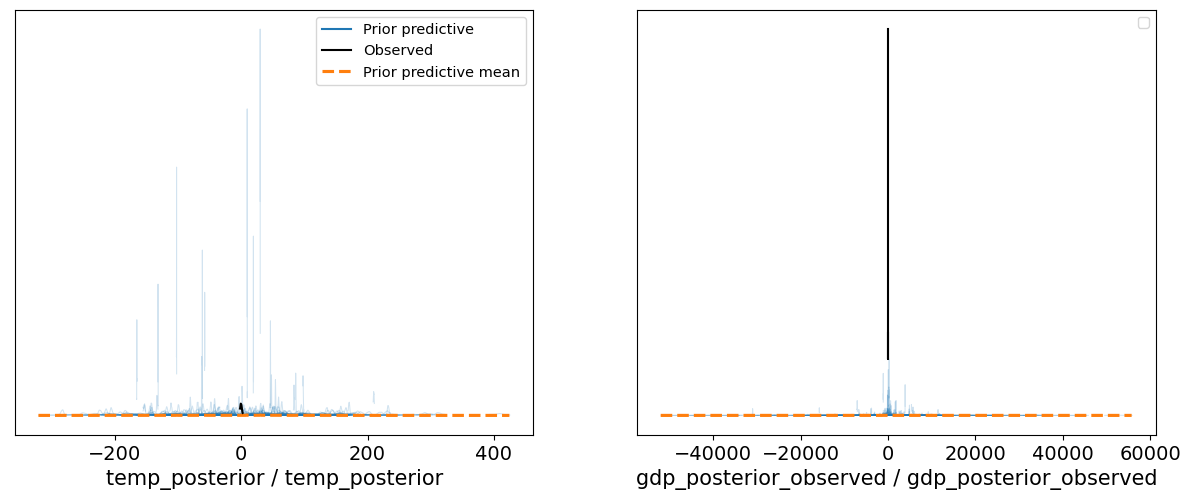

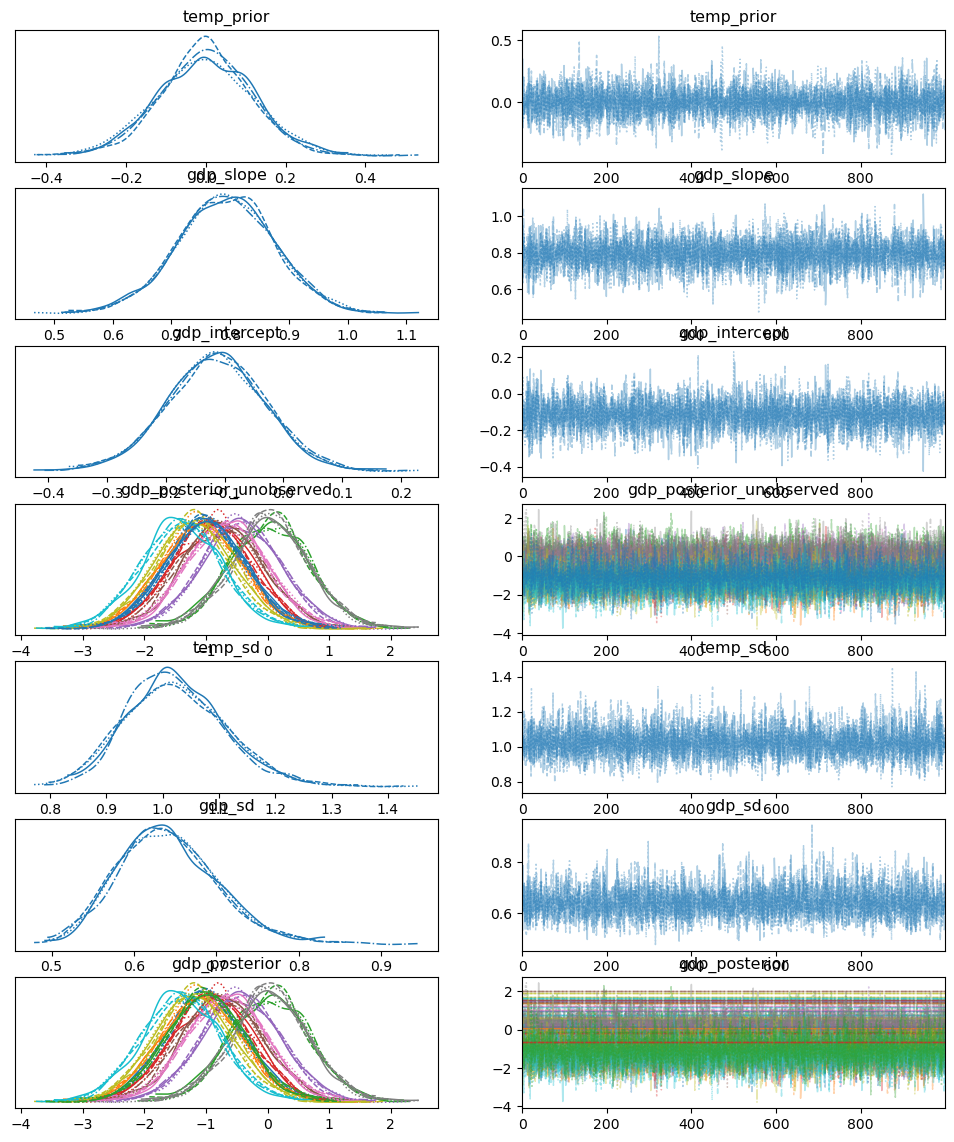

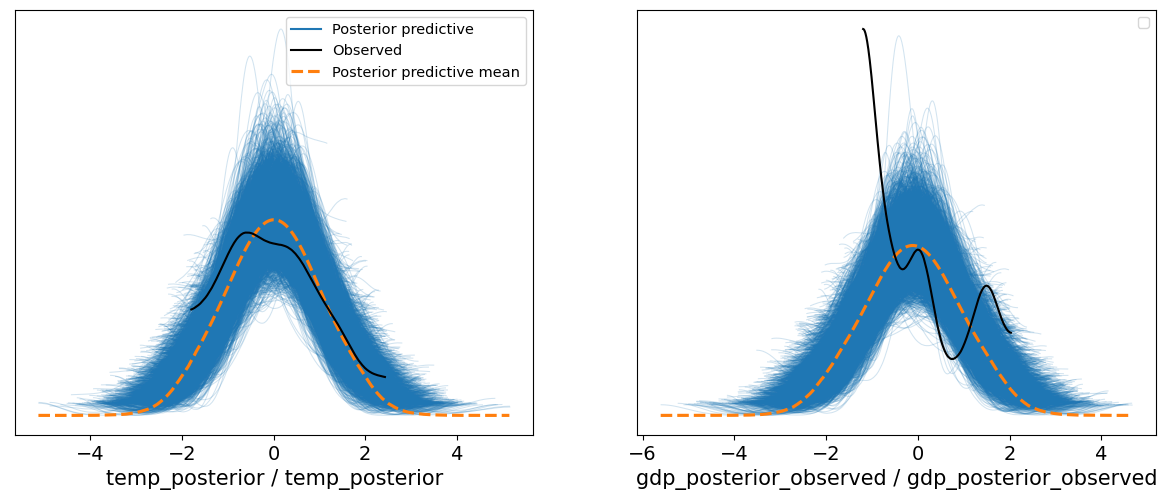

In [62]:
fig = az.plot_ppc(prior, group="prior").ravel()[0].figure
# fig = az.plot_ppc(prior, group="prior").figure
fig.show()
fig = az.plot_trace(trace).ravel()[0].figure
fig.show()
fig = az.plot_ppc(posterior).ravel()[0].figure
# fig = az.plot_ppc(posterior).figure
fig.show()

In [65]:
# What is the approximated linear relationship between global temperature and gdp-per-capita at the global level?
slope = np.mean(np.array(posterior["posterior"]["gdp_slope"].data[0]))
intercept = np.mean(np.array(posterior["posterior"]["gdp_intercept"].data[0]))
print(slope,intercept)

0.7927233563594753 -0.11569374156730697


# Globally we show GDP per capita has increased with temperature
# Now we try to reproduce the result by using the global temperature variable to aggregate individual country level temperature

In [125]:
global_gdp_observed_local_aggregate_model = []
global_temp_observed_local_aggregate_model = []
country_temp_observed_data = {}
country_gdp_observed_data = {}
all_years = set()
all_countries = set()

for country, data in avg_country_temp_per_year.items():
    if country in country_gdp_per_year:
        all_countries.add(country)
    for year in data:
        all_years.add(year)
for country, data in country_gdp_per_year.items():
    if country in all_countries:
        for year in data:
            all_years.add(year)

for year in all_years:
    if year in global_gdp:
        global_gdp_observed_local_aggregate_model.append(global_gdp[year])
    if year in global_temperature:
        global_temp_observed_local_aggregate_model.append(global_temperature[year])
    else:
        global_temp_observed_local_aggregate_model.append(np.NaN)
    for country in all_countries:
        if country not in country_temp_observed_data:
            country_temp_observed_data[country] = []
        if country not in country_gdp_observed_data:
            country_gdp_observed_data[country] = []
        if year in avg_country_temp_per_year[country]:
            country_temp_observed_data[country].append(avg_country_temp_per_year[country][year])
        else:
            country_temp_observed_data[country].append(np.NaN)
        if year in country_gdp_per_year[country]:
            country_gdp_observed_data[country].append(country_gdp_per_year[country][year])
        else:
            country_gdp_observed_data[country].append(np.NaN)

In [126]:
# normalize data
# normalize observed data
country_temp_scalers = {}
country_gdp_scalers = {}

normalized_country_temp_data = {}
normalized_country_gdp_data = {}

global_gdp_local_aggregater_model_scaler = StandardScaler()
global_temp_local_aggregater_model_scaler = StandardScaler()

for country in country_temp_observed_data:
    country_temp_scalers[country] = StandardScaler()
    normalized_country_temp_data[country] = country_temp_scalers[country].fit_transform(np.array(country_temp_observed_data[country]).reshape(-1, 1)).flatten()
    country_gdp_scalers[country] = StandardScaler()
    normalized_country_gdp_data[country] = country_gdp_scalers[country].fit_transform(np.array(country_gdp_observed_data[country]).reshape(-1, 1)).flatten()

normalized_global_gdp_local_aggregate_model = global_gdp_local_aggregater_model_scaler.fit_transform(np.array(global_gdp_observed_local_aggregate_model).reshape(-1, 1)).flatten()
normalized_global_temp_local_aggregate_model = global_temp_local_aggregater_model_scaler.fit_transform(np.array(global_temp_observed_local_aggregate_model).reshape(-1, 1)).flatten()

In [158]:
ordered_country_list = list(all_countries)
observed_normalized_country_temp_data = [normalized_country_temp_data[country] for country in ordered_country_list]
observed_normalized_country_gdp_data = [normalized_country_gdp_data[country] for country in ordered_country_list]

with pm.Model() as model:

    global_temp_prior = pm.Normal("temp_prior", 0, 100)
    global_temp_sd = pm.HalfNormal("temp_sd", 10)
    global_temp_posterior = pm.Normal("temp_posterior", global_temp_prior, global_temp_sd, observed=normalized_global_temp_local_aggregate_model)

    country_temp_coefs = pm.Normal("country_temp_coefs", 0, 10, shape=(len(normalized_country_temp_data),len(normalized_global_temp_local_aggregate_model)))    
    # need to add an intercept term here
    country_temp_priors = global_temp_posterior * country_temp_coefs
    country_temp_sds =  pt.expand_dims(pm.HalfNormal("country_temp_sds", 10, shape=(len(normalized_country_temp_data))), axis=(1,))
    country_temp_posteriors = pm.Normal("country_temp_posteriors", country_temp_priors, country_temp_sds, observed=observed_normalized_country_temp_data)
    
    country_gdp_coefs = pm.Normal("country_gdp_coefs", 0, 10, shape=(len(normalized_country_gdp_data),len(normalized_global_gdp_local_aggregate_model)))
    # need to add an intercept term here
    country_gdp_priors = country_temp_posteriors * country_gdp_coefs
    country_gdp_sds = pt.expand_dims(pm.HalfNormal("country_gdp_sds", 10, shape=(len(normalized_country_gdp_data))), axis=(1,))
    country_gdp_posteriors = pm.Normal("country_gdp_posteriors", country_gdp_priors, country_gdp_sds, observed=observed_normalized_country_gdp_data)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in country_temp_posteriors contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in country_gdp_posteriors contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16571E900>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: R

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3923 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 280 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
/Users/hayden.freedman/mini

In [161]:
with open ('models/global_temp_local_gdp.pkl', 'wb') as buff:
    pkl.dump ({'prior': prior, 'trace': trace, "posterior": posterior}, buff)

In [163]:
canada_index = ordered_country_list.index("Canada")
brazil_index = ordered_country_list.index("Brazil")

# What is the approximated linear relationship between global temperature and gdp-per-capita at the global level?
canada_slope = np.mean(np.array(posterior["posterior"]["country_gdp_coefs"].data[0][canada_index]))
brazil_slope = np.mean(np.array(posterior["posterior"]["country_gdp_coefs"].data[0][brazil_index]))
print(canada_slope, brazil_slope)

-0.1256749650739295 -0.08967389241311984


In [172]:
print(len(data["posterior"]["posterior"]["country_gdp_coefs"][0][0][0].data))

61


In [171]:
with open('models/global_temp_local_gdp.pkl', 'rb') as buff:
    data = pkl.load(buff)
    print(data["prior"])
    print(data["trace"])
    print(data["posterior"])

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
